<a href="https://colab.research.google.com/github/matheusrbg/Reconhecimento-do-Alfabeto-em-Libras/blob/main/vgg19bn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()
use_gpu

True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !unzip -n /content/drive/MyDrive/LIBRAS/test.zip -d /content/drive/MyDrive/LIBRAS/ 

# Preprocessing

In [4]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
data_dir = "drive/MyDrive/LIBRAS"

image_datasets = {
    x: datasets.ImageFolder(
        root=os.path.join(data_dir, x), 
        transform=transform
    )
    for x in ['train', 'test']
}
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=32,
        shuffle=True, num_workers=2
    )
    for x in ['train', 'test']
}
pathloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x].imgs, batch_size=32,
        shuffle=True, num_workers=2
    )
    for x in ['train', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train',  'test']}

In [6]:
for x in ['train', 'test']:
    print("Loaded {} images in {}".format(dataset_sizes[x], x))
    
print("Classes: ")

label = image_datasets['test'].classes
print(image_datasets['train'].classes)
print(label)

Loaded 34714 images in train
Loaded 11521 images in test
Classes: 
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']


# Creating Model

In [7]:
num_classes = len(os.listdir(data_dir + '/train'))
num_epochs = 5
batch_size = 64
learning_rate = 0.0005

model = torchvision.models.vgg19_bn(weights="IMAGENET1K_V1")

if use_gpu:
  model.to(device)

# Newly created modules have require_grad=True by default
num_features = model.classifier[6].in_features
features = list(model.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, num_classes)]) # Add our layer with 4 outputs
model.classifier = nn.Sequential(*features) # Replace the model classifier

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  

# Visualizing

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[label[x] for x in classes])

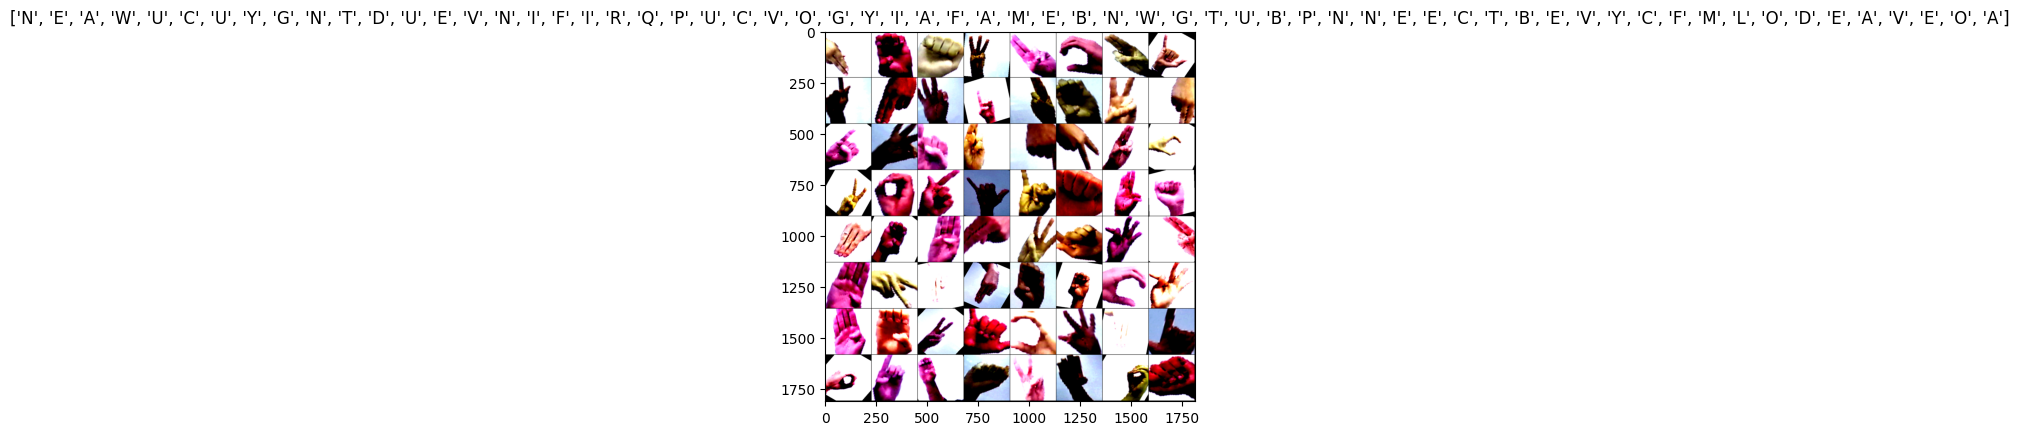

In [10]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[label[x] for x in classes])

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0
    
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    model.train(mode=was_training)

Ground truth:


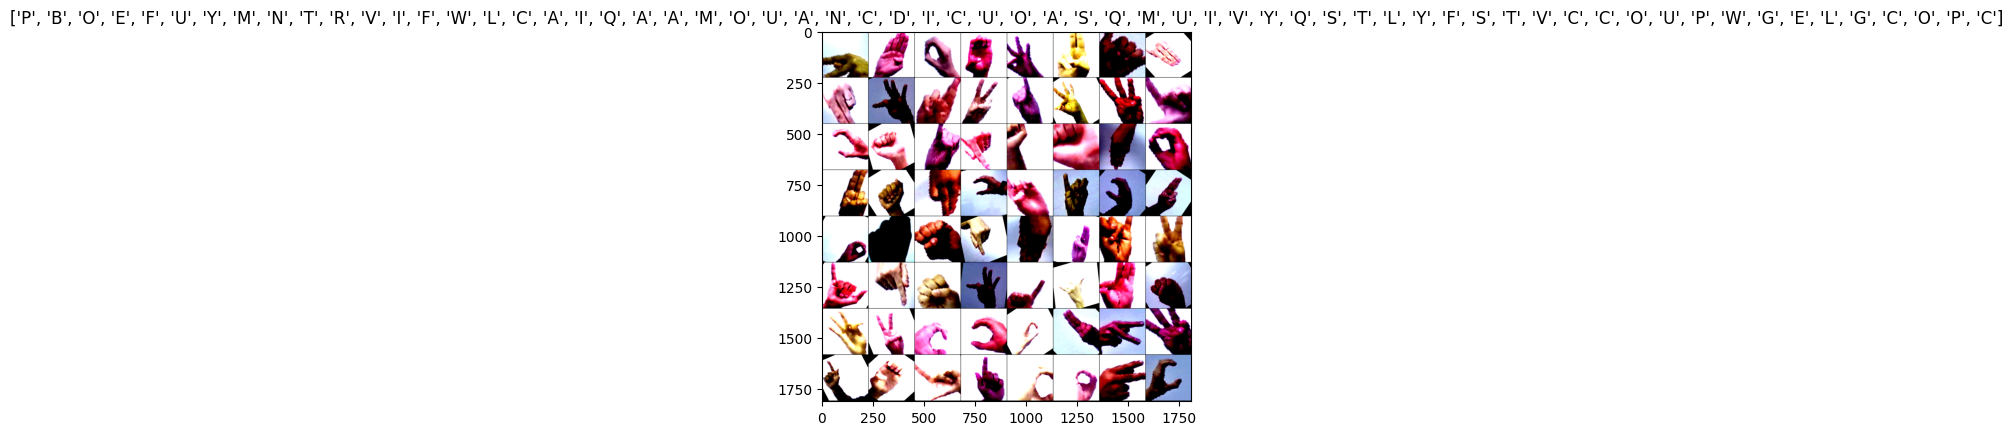

Prediction:


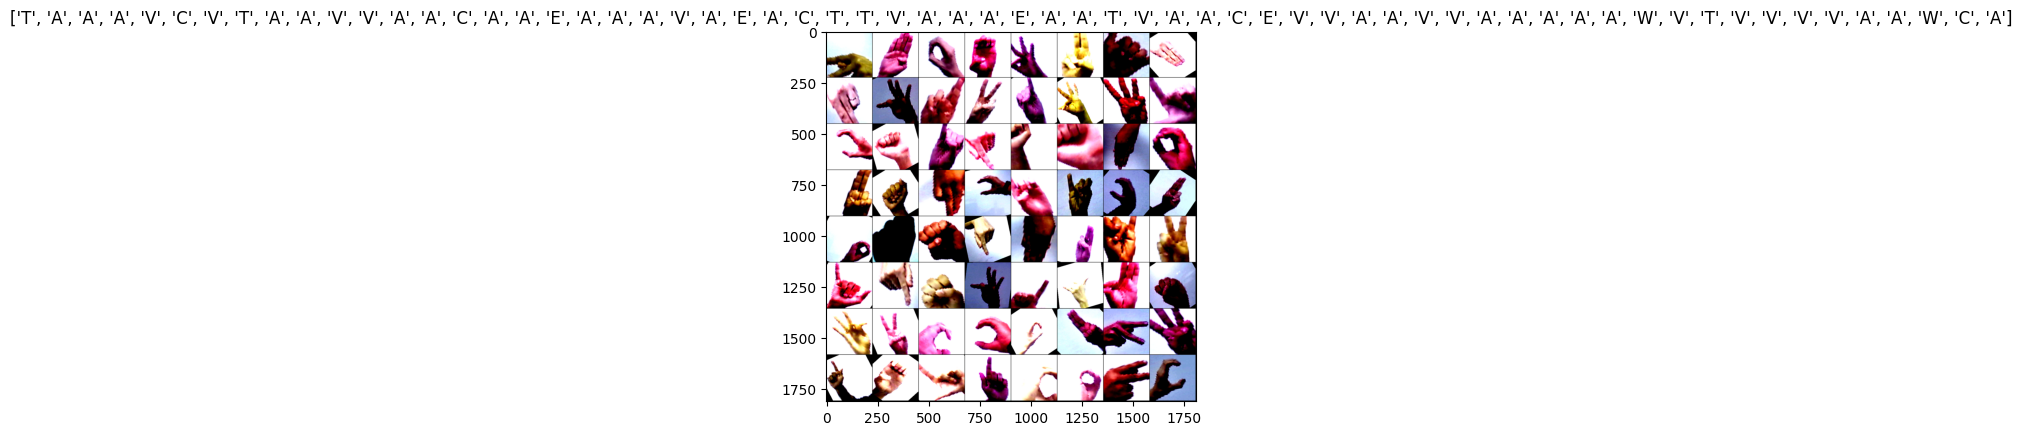

In [12]:
visualize_model(model)

# Training

In [13]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=5):
    if use_gpu:
        with torch.no_grad():
            vgg = vgg.to(device)

    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    
    loss_values = []
    acc_values = []
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs-1))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders['train']):
            
            print("\rTraining batch {}/{}".format(i+1, train_batches), end='', flush=True)
                
            inputs, labels= data
            
            if use_gpu:
                with torch.no_grad():
                    inputs, labels = inputs.cuda(), labels.cuda()
            else:
                with torch.no_grad():
                    inputs, labels = inputs, labels
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / dataset_sizes['train']
        avg_acc = acc_train  / dataset_sizes['train']
        loss_values.append(avg_loss)
        acc_values.append(avg_acc)
        vgg.train(False)
        vgg.eval()
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))

        print('-' * 10)
        print()
        
        if avg_acc > best_acc:
            best_acc = avg_acc
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg,acc_values,loss_values

In [14]:
model,acc,loss = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)
torch.save(model.state_dict(),'VGG19_libras.pt')

Epoch 0/4
----------
Training batch 543/543

Epoch 0 result: 
Avg loss (train): 0.0139
Avg acc (train): 0.7411
----------

Epoch 1/4
----------
Training batch 543/543

Epoch 1 result: 
Avg loss (train): 0.0011
Avg acc (train): 0.9799
----------

Epoch 2/4
----------
Training batch 543/543

Epoch 2 result: 
Avg loss (train): 0.0006
Avg acc (train): 0.9897
----------

Epoch 3/4
----------
Training batch 543/543

Epoch 3 result: 
Avg loss (train): 0.0004
Avg acc (train): 0.9931
----------

Epoch 4/4
----------
Training batch 543/543

Epoch 4 result: 
Avg loss (train): 0.0003
Avg acc (train): 0.9955
----------


Training completed in 57m 18s
Best acc: 0.9955


Text(0.5, 1.0, 'VGG loss')

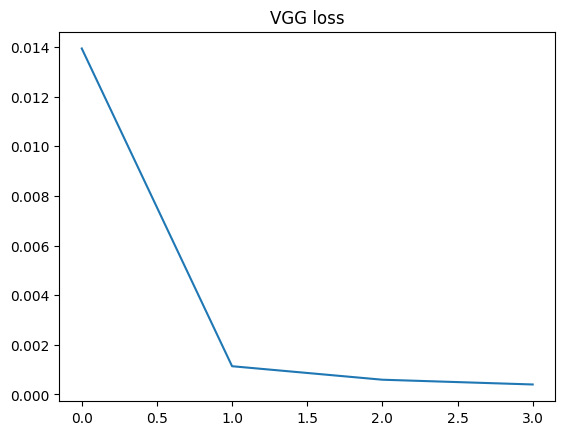

In [16]:
plt.plot([it for it in loss[:-1]])
plt.title("VGG loss")

In [21]:
!ls

drive  sample_data  VGG19_libras.pt


In [24]:
!cp  VGG19_libras.pt drive/MyDrive/LIBRAS

# Evaluating

In [8]:
PATH = "drive/MyDrive/LIBRAS/VGG19_libras.pt"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [9]:
def eval_model(model, criterion):
    if use_gpu:
        with torch.no_grad():
            model = model.to(device)

    y_true = []
    y_pred = []
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['test'])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders['test']):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        model.train(False)
        model.eval()
        
        inputs, labels = data
        
        y_true = y_true + labels.tolist()
        if use_gpu:
            with torch.no_grad():
                inputs, labels = inputs.cuda(), labels.cuda()
        else:
            with torch.no_grad():
                inputs, labels = inputs, labels
        
        outputs = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        #print(preds)
        y_pred = y_pred + preds.tolist()
        
        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['test']
    avg_acc = acc_test / dataset_sizes['test']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)
    return y_true,y_pred

In [10]:
criterion = nn.CrossEntropyLoss()
eval_model(model, criterion)

Evaluating model
----------
Test batch 300/361
Evaluation completed in 1m 58s
Avg loss (test): 0.0005
Avg acc (test): 0.9951
----------


([5,
  2,
  4,
  10,
  3,
  8,
  0,
  14,
  2,
  18,
  18,
  8,
  11,
  3,
  20,
  3,
  15,
  14,
  7,
  4,
  17,
  6,
  12,
  6,
  8,
  16,
  7,
  14,
  12,
  12,
  2,
  12,
  0,
  20,
  4,
  10,
  18,
  15,
  20,
  0,
  10,
  18,
  6,
  14,
  17,
  5,
  14,
  9,
  4,
  14,
  11,
  14,
  9,
  10,
  4,
  8,
  13,
  16,
  18,
  15,
  10,
  18,
  8,
  19,
  13,
  12,
  1,
  10,
  10,
  2,
  10,
  5,
  7,
  6,
  16,
  6,
  16,
  5,
  18,
  6,
  8,
  6,
  19,
  13,
  8,
  12,
  12,
  7,
  2,
  7,
  9,
  2,
  17,
  2,
  19,
  5,
  13,
  11,
  1,
  10,
  4,
  10,
  9,
  0,
  19,
  0,
  18,
  6,
  7,
  8,
  14,
  18,
  7,
  3,
  15,
  8,
  18,
  17,
  12,
  3,
  5,
  0,
  12,
  10,
  12,
  8,
  1,
  18,
  8,
  9,
  11,
  16,
  14,
  13,
  3,
  15,
  19,
  17,
  9,
  7,
  18,
  20,
  10,
  10,
  10,
  18,
  14,
  10,
  0,
  15,
  4,
  12,
  20,
  0,
  7,
  2,
  8,
  12,
  14,
  11,
  13,
  14,
  7,
  19,
  12,
  0,
  11,
  18,
  17,
  5,
  11,
  5,
  18,
  20,
  11,
  16,
  2,
  0,
  8,
  0,
 